# Abstract

A/B testing is the usual standard for understanding the effects of different treatments. A prominent use case is testing potential new product features. While A/B testing is great for clearly identifying the difference in important business metrics, it lacks the ability to purposely target specific customers. To accomodate for this change, companies can use quasi-experimental methods to extract a difference in experience measurement. In this post, we demonstrate regression discontinuity in the context of a music streaming company. Using this quasi-experimental method, we show that a company can offer an "exclusive" product experience while still holding the ability to extract causal effects.

# Introduction

**PlayMe**, a new US-based music streaming company, aims to differentiate itself from major competitors like Spotify and Apple Music. It plans to do this by offering state-of-the-art AI personalization. Leveraging the power of large language models (LLMs), PlayMe is building its music streaming experience around this technology. By immediately positioning itself as an AI streaming player, PlayMe intends to disrupt the music streaming industry.

Among its current features, PlayMe is preparing to release an **AI DJ**. Currently, the service offers two main options: a home page with personalized song recommendations and AI-curated playlists, and a search function for specific tracks. The new AI DJ feature is designed to simplify the user experience by eliminating the need for users to browse through different playlists or search for specific songs. The proposed addition is found in @fig-app-1.

![Current layout and Proposed Update](playme_app.jpg){#fig-app-1}

The AI DJ addition comes from current product analysis. Users who spend too much time searching for songs, in the search function or by skipping songs, end up having much shorter listening sessions than those who are consistently listening to music. @tbl-app-1 shows this relationship.

| avg time to first skip | avg session length |
|---|---|
| <2.0 | 10.0 |
| >2.0 | 15.0 |

: PlayMe Product Analysis {#tbl-app-1}

As we can see from @tbl-app-1, users who take less than 2 minutes to take their first skip have an average session length of about 10 minutes. Compared to users who take more than 2 minutes to take their first skip, their average session length is 5 minutes longer. 

The theory behind the AI DJ feature is simple: by providing a seamless flow of highly relevant songs, we can increase our users' average session lengths. This, in turn, will enhance their overall experience and build stronger loyalty to the app.

## Search Theory

The AI DJ and other PlayMe features are practical applications of search theory [@Stigler1961]. From an economics standpoint, users are agents searching for "information" or "goods"—in this case, music. Search theory provides frameworks that help us reduce the friction, or cost, for our users to find what they want.

On PlayMe and other streaming services, it's essential to maintain a large music library to ensure users have a wide range of choices. The primary challenge, then, is to design search features that minimize the time users spend trying to find their desired music.

When users begin a session on PlayMe, they are typically in one of two mindsets: focused search or exploratory search [@Li2019]. To help those in the focused category, the search function allows them to find specific songs. For users in the exploratory group, the app generates curated playlists and song suggestions based on their listening history.

By lowering the cost of search, we gather more user data. This data then enhances our personalization algorithms and informs our overall product strategy. Furthermore, this process increases user loyalty by raising their **switching costs**. The more a user listens on PlayMe, the more the app learns their tastes, making it increasingly difficult for them to switch to a competitor and start their personalization journey over.

## Testing a Premium Product

In most cases, a company would test a new product through some user tests done in-house and then a larger rollout through A/B testing. However, PlayMe doesn't want to perform just a normal A/B test. They want this new feature to an "exclusive reward" for their most loyal and active customers.

PlayMe plans to offer the new AI DJ feature exclusively to users who average at least 30 minutes per session. This strategy serves a dual purpose. First, it rewards the app's most active customers with early access. Second, it creates an exclusive "club" that may motivate other users to increase their session lengths in hopes of being included in future product tests.

In a standard A/B test, it's fairly straightforward to measure the effects of distinct treatments since we have clear control and experimental groups. However, in this scenario, the product is rolled out exclusively to a group of users who already have high engagement metrics. The challenge, therefore, is to identify a suitable comparison group to ensure we can draw a valid inference about the success of the new AI DJ feature.

# Regression Discontinuity Design (RDD)

As previously discussed, how can we properly extract a causal estimate of our treatment while still offering an exclusive experience to our most avid users? One method is regression discontinuity [@Campbell1960]. At a high level, the idea is simple: the difference between users just above and just below the treatment cutoff is marginal—in effect, it is nearly "random." Therefore, regression discontinuity models the "jump" in outcomes between the treated group and those who just barely missed the cutoff.

From the information above, we know that only users who average at least 30 minutes per session get the treatment. Thus, users who were very close (e.g. 29 minute average session) would be non-treated and would be part of our control group. From a purely experimental design perspective, our product rollout appears to meet the criteria to perform regression discontinuity. To further solidify this track, we can begin to explore the data.

## EDA

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz as gr

import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

In [2]:
#Define synthetic data function
def get_syn_data(n_obs, r_seed=42):
    np.random.seed(r_seed)
    
    data_dict = {
        'avg_sess': [],
        'age': [],
        'gender': [],
        'main_device': [],
        'has_dj': [],
        'use_dj': [],
        'avg_time_skip': []
    }
    dj_use = .9
    true_params = {
        'base': 3,
        'phone': {
            'avg_sess': .05,
            'use_dj': 5
        },
        'laptop': {
            'avg_sess': .05,
            'use_dj': 3,
            'is_laptop': -1
        }
    }
    
    for i in range(n_obs):
        avg_sess = np.random.normal(30, 5)
        rand_num = np.random.uniform()
        has_dj = np.where((avg_sess > 30), 1, 0).item()
        use_dj = np.where((dj_use > rand_num) & (avg_sess > 30), 1, 0).item()
        gender = np.random.choice(['m', 'f'])
        device = np.random.choice(['phone', 'laptop'], p=[.6, .4])
        age = round(np.random.normal(25, 2))
        avg_time_skip = 0
        
        if device == 'phone':
            avg_time_skip = true_params['base'] + (true_params['phone']['avg_sess'] * avg_sess) + (true_params['phone']['use_dj'] * use_dj) + np.random.normal(0, 1)
        else:
            avg_time_skip = true_params['base'] + true_params['laptop']['is_laptop'] + (true_params['laptop']['avg_sess'] * avg_sess) + (true_params['laptop']['use_dj'] * use_dj)
            
        data_dict['avg_sess'].append(avg_sess)
        data_dict['age'].append(age)
        data_dict['gender'].append(gender)
        data_dict['main_device'].append(device)
        data_dict['has_dj'].append(has_dj)
        data_dict['use_dj'].append(use_dj)
        data_dict['avg_time_skip'].append(avg_time_skip)
        
    
    return pd.DataFrame(data_dict)

In [3]:
#Generate data
df = get_syn_data(500)

We begin our EDA by modeling plotting the distribution of average session length in minutes (Note: This distribution only contains our more "active" listeners). This distribution is shown in @fig-eda-1.

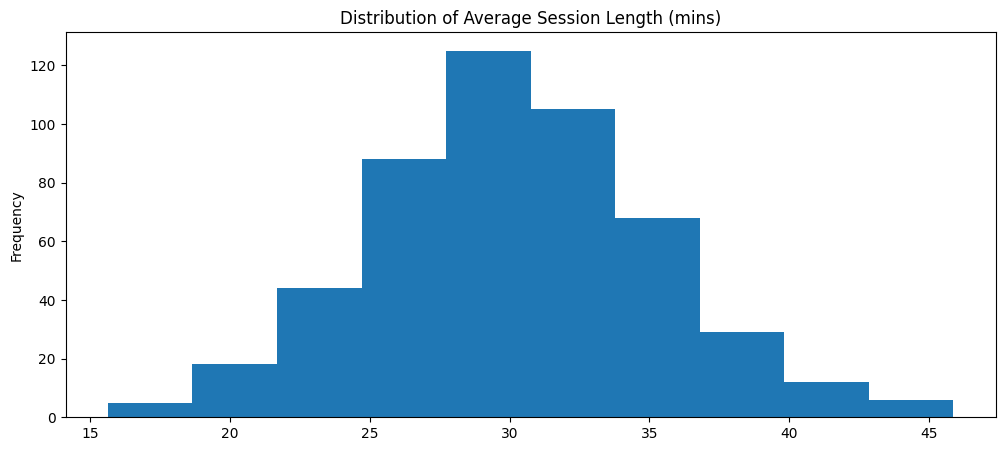

In [4]:
#| label: fig-eda-1
#| fig-cap: "Top listener average session length distribution in minutes"

#Show distribution of avg_sess
fig, ax = plt.subplots(figsize=(12,5))

df['avg_sess'].plot(kind='hist', ax=ax)
ax.set_title("Distribution of Average Session Length (mins)");

The distribution appears to be approximately normal and fairly centered around 30 minutes. This would imply that we are applying the treatment to those who are above average listeners in our core listener group. The next plot, @fig-eda-2, shows the count of those who received treatment (DJ) vs no treatment.

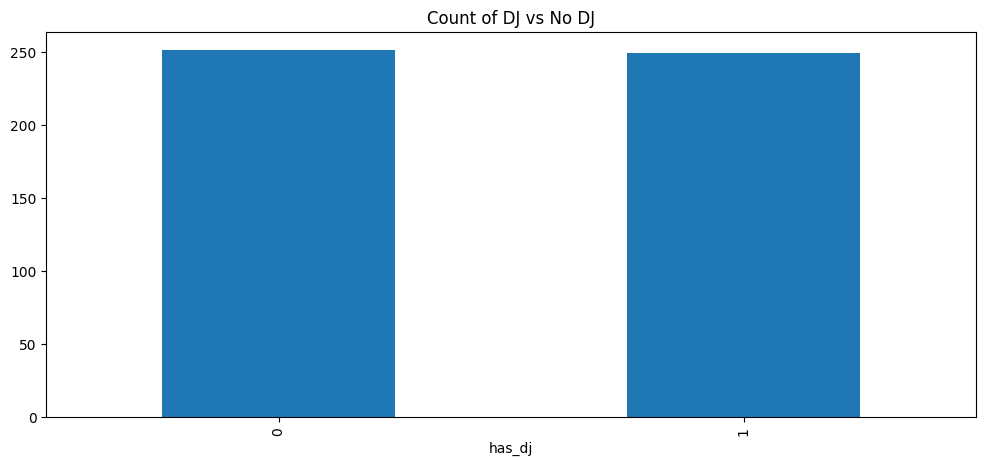

In [5]:
#| label: fig-eda-2
#| fig-cap: "Barplot of count data for those untreated (0) and treated (1)"

#Show count of has dj vs no dj
fig, ax = plt.subplots(figsize=(12,5))

df['has_dj'].value_counts().plot(kind='bar', ax=ax)
ax.set_title("Count of DJ vs No DJ");

The barplot clearly indicates a fairly even split between treated vs untreated individuals. To illustrate if there is a jump in the data, we can view @fig-eda-3.

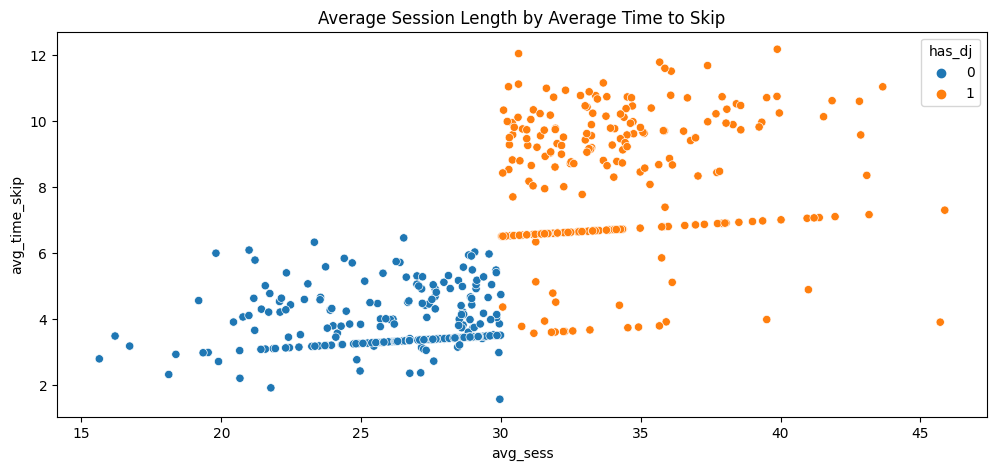

In [6]:
#| label: fig-eda-3
#| fig-cap: "Scatterplot showing average session length by average time to first skip, split by treated and untreated"

#Show jump due to treatment
fig, ax = plt.subplots(figsize=(12, 5))

sns.scatterplot(x=df['avg_sess'], y=df['avg_time_skip'], hue=df['has_dj'], ax=ax)
ax.set_title("Average Session Length by Average Time to Skip");

We can see a slight jump in the data at the 30 minute mark along the x axis. It appears that most of those who were treated have higher average time to skip than those who were untreated. However, we see that there are a few treated dots that follow the trend of the untreated. 

In our scenario, this is a case of **non-compliance**. That is, even though some users qualified for the DJ, they chose not to use the DJ. We will have to account for this in our model later on.

To continue with the EDA, our data also includes primary device type of users. @fig-eda-4 shows the distribution for each respective device.

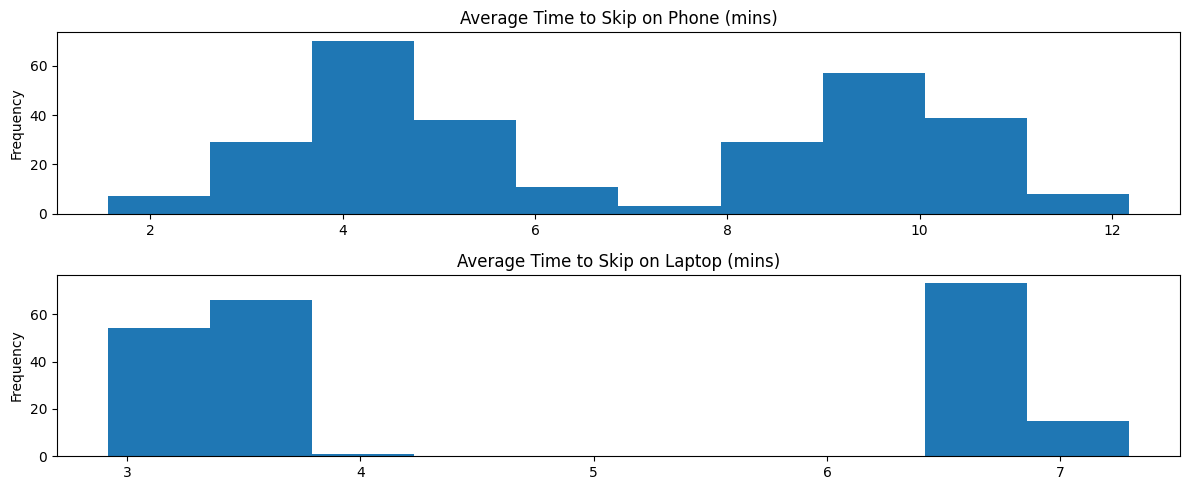

In [7]:
#| label: fig-eda-4
#| fig-cap: "Distributions of average time to skip for phone users (top panel) and laptop users (bottom panel)"

#Compare distributions of avg_time_skip by device
fig, ax = plt.subplots(2, 1, figsize=(12,5))

df.query("main_device == 'phone'")['avg_time_skip'].plot(kind='hist', ax=ax[0])
ax[0].set_title("Average Time to Skip on Phone (mins)")

df.query("main_device == 'laptop'")['avg_time_skip'].plot(kind='hist', ax=ax[1])
ax[1].set_title("Average Time to Skip on Laptop (mins)")

fig.tight_layout();

Both distributions appear to be bimodal (probably due to difference in treated vs untreated). Furthermore, the right peak on the phone distribution appears to have a higher mean than that of the laptop distritbution. There could be some interactive effect between having the DJ and the kind of device used. We can include this in our model specification.

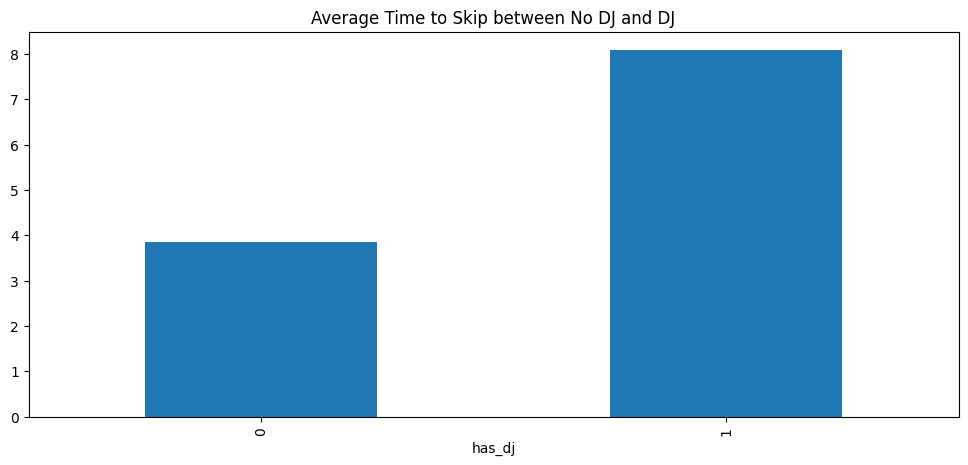

In [8]:
#| output: false

#Compare avg_time_skip by dj
fig, ax = plt.subplots(figsize=(12,5))

df.groupby(['has_dj'])['avg_time_skip'].mean().plot(kind='bar', ax=ax)
ax.set_title("Average Time to Skip between No DJ and DJ");

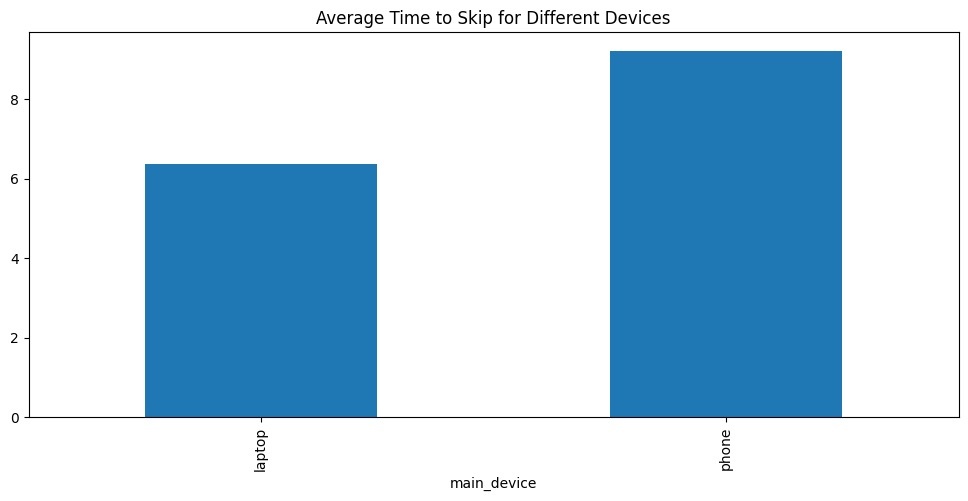

In [9]:
#| output: false

#Compare avg_time_skip by dj and device
fig, ax = plt.subplots(figsize=(12,5))

df.query("has_dj == 1").groupby(['main_device'])['avg_time_skip'].mean().plot(kind='bar', ax=ax)
ax.set_title("Average Time to Skip for Different Devices");

Returning for a moment to the potential non-compliance issue, we can verify this by checking the proportion of users who used the DJ, given they were assigned the DJ.

In [10]:
#Show the percent of users that were assigned dj but did not use it
df.query("has_dj == 1")['use_dj'].value_counts(normalize=True)

use_dj
1    0.895582
0    0.104418
Name: proportion, dtype: float64

About 10% of users who were assigned the DJ did not use the DJ feature. This is a strong indicator of non-compliance which we should account for in our model.

## Model Specification

The goal of our model is to extract a valid causal estimate of our DJ feature on average time to skip. To do this, we need to specify a model that accounts for: the discontinuity between treated and untreated and the non-compliance of some in the treated group. The first part is just utilizing a linear regression model. The second part means we need to adjust this regression model to be a **two-stage least squares (2SLS)** [@Theil1953] model.

A 2SLS model contains two parts: the first-stage regression and the second-stage regression (hence, two-stage). The first-stage model is found in @eq-2sls-1.

$$
D_{i} = \gamma_{0} + \gamma_{1}X_{i} + \gamma_{2}T_{i} + \sum_{j=3}^{m}\gamma_{j}Z_{ji} + \epsilon_{i}
$${#eq-2sls-1}

The first-stage regression models the treatment status (1 for DJ, 0 for no DJ) for each individual $i$. $X_{i}$ is our running variable (average session length) for each individual $i$. $T_{i}$ is the instrument variable. We need the instrument variable to adjust for non-compliance since the treatment status is endogenous (i.e. correlated with the error term). To get an unbiased estimate, we use the instrument of assignment. That is, the treatment variable is a binary indicator of 1 if the user used the DJ and 0 otherwise. The instrument variable is a binary indicator of 1 if the user was assigned the DJ and 0 otherwise. The rest of the model are other covariates that help us to control for potential confounders (e.g. age, device type, etc.).

The second-stage of the 2SLS estimates our variable of interest. In this case, average time to first skip. The second-stage model is shown in @eq-2sls-2.

$$
ln(Y_{i}) = \beta_{0} + \beta_{1}X_{i} + \beta_{2}\hat{D}_{i} + \sum_{j=3}^{m}\beta_{j}Z_{ji} + u_{i}
$${#eq-2sls-2}

In our model, we perform a log transformation to understand the percent change our treatment yields compared to the control group. The only real difference between @eq-2sls-1 and @eq-2sls-2 is $\hat{D}$. This is the predicted treatment status from @eq-2sls-1. Using this model, we can calculate the **local average treatment effect (LATE)**, since we only want to measure the effect between those who complied with the treatment (i.e. those who actually used the DJ and were assigned it vs those who did not use the DJ and were not assigned it). 

## Model Results

The key parameter of interest is the treatment parameter, `use_dj`. Based on our EDA, we should expect a positive effect of DJ. Another parameter of interest would be the interaction term between `use_dj` and `device_laptop` to see if there is a difference of DJ effect by device type (Note: Mobile device is the baseline device in the model). Below is the output from our model.

In [11]:
#Get dummies
df = (df.pipe(lambda x: pd.get_dummies(x, columns=['gender', 'main_device'], dtype=int))
 .drop(['gender_m', 'main_device_phone'], axis=1)
 .assign(log_avg_time_skip = lambda x: np.log(x.avg_time_skip))
 .assign(use_term_device = lambda x: x.use_dj * x.main_device_laptop)
 .assign(has_term_device = lambda x: x.has_dj * x.main_device_laptop))

In [12]:
#Run 2SLS
formula = "log_avg_time_skip ~ 1 + avg_sess + age + gender_f + main_device_laptop + use_term_device + [use_dj ~ has_dj]"
mod = IV2SLS.from_formula(formula, df).fit()

In [13]:
mod.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,1.2795,0.0997,12.830,0.0000,1.0841,1.4750
avg_sess,0.0087,0.0025,3.5188,0.0004,0.0039,0.0136
age,-0.0031,0.0030,-1.0469,0.2951,-0.0090,0.0027
gender_f,-0.0116,0.0129,-0.9007,0.3677,-0.0368,0.0136
main_device_laptop,-0.2214,0.0206,-10.737,0.0000,-0.2618,-0.1810
use_term_device,-0.1514,0.0256,-5.9048,0.0000,-0.2016,-0.1011
use_dj,0.7834,0.0336,23.300,0.0000,0.7175,0.8493


At face value, the `use_dj` parameter shows a significant result. On average, users who used the AI DJ saw a log increase in average time to first skip of 0.7834. Additionally, those who used a laptop instead of a mobile device with the DJ saw a decrease in the DJ effect. That is, the DJ effect for laptop users was a log increase of ~0.63. To understand these values on a percentage scale, we can transform them by $(e^{X} - 1) * 100$. Below is the tranformation for `use_dj` for mobile and `use_dj` for laptop.

In [21]:
print(f"use_dj (mobile): {(np.exp(mod.params[6]) - 1) * 100}")
print(f"use_dj (laptop): {(np.exp(mod.params[6] + mod.params[5]) - 1) * 100}")

use_dj: 118.9002474395752
use_term_device: 88.1520550200446


According to our model, those who used the DJ saw a 118\% increase in average time to first skip. That is a huge improvement! This effect represents the average percent increase in users who use mobile as their primary device (along with other covariates but won't mention here). To calculate the effect of the treatment for laptop users, we combine the baseline effect with the interaction term in the transformation formula. This yields a 88% increase in average time to first skip for laptop users (still a great increase!).

While these estimates are exciting, we would want to verify that the model passes the standard assumptions for regression discontinuity. We won't go into too much detail in this post on how to verify, but readers should be aware of key assumptions like continuity of the conditional mean, no manipulations of the running variable, etc. 

# Conclusion

The goal of this post was to demonstrate the usefulness of a quasi-experimental method in extracting causal inference while still providing exclusive experiences to customers who we believed deserved them. We planned a carefully designed study where those who listened on average over 30 minutes in a session would receive the treatment and those below the threshold would not. Using regression discontinuity and log-transforming the model, we found the causal estimate of the DJ program. Furthermore, since we had some who were "non-compliers" of DJ treatment assignment, we adjusted the model to account for this and estimated the LATE. 

The next steps for PlayMe would be to form a strategy around these findings. Should PlayMe roll this out to all their customers? Keep it just for top listeners? PlayMe ideally would have had this in mind before performing the experiment, but no time like the present to plan on how to use their new tool. From the results, we recommend that PlayMe expand the DJ assignment to more users (perhaps those who average 20 minutes or more in a session). From here, PlayMe can continue to analyze data and run more experiments to understand if they should keep it as an exclusive or have it be a prominent feature for all their users. 